In [1]:
!pip install qiskit;
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

from IPython.display import clear_output
clear_output()

<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-8c9b8448056a>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  label = 'Malignant' if k is 1 else 'Benign'


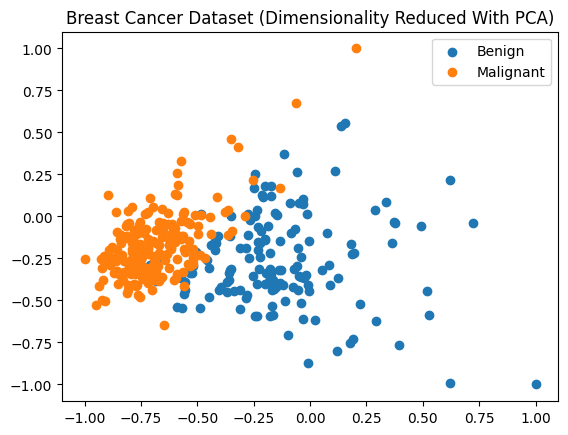

Training data shape: (349, 2)
Testing data shape: (49, 2)


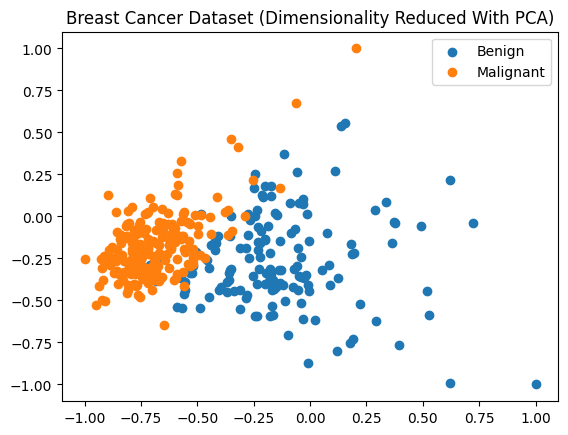

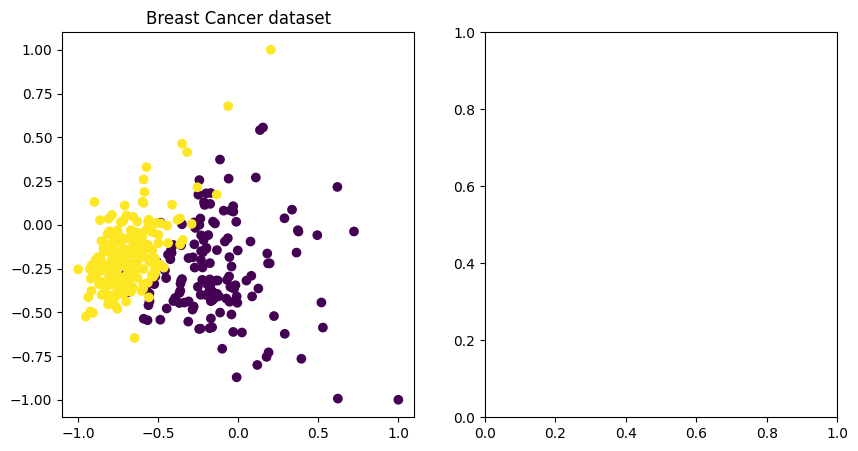

In [2]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']

    # First the dataset must be imported.
    cancer = datasets.load_breast_cancer()

    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
    X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)

    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]

            label = 'Malignant' if k is 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()


    return X_train, training_input, test_input, class_labels

def split_dataset_to_data_and_labels(input_data):
    data = []
    labels = []
    for label, features in input_data.items():
        data.append(features)
        # Convert labels to 0 and 1
        if label == 'Benign':
            labels.append([0] * len(features))
        else:
            labels.append([1] * len(features))
    return np.vstack(data), np.hstack(labels)

# Set parameters
n = 2  # Number of principal components
training_dataset_size = 200
testing_dataset_size = 100

# Get the dataset and split it
sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

# Split dataset into data and labels
data_train, train_labels = split_dataset_to_data_and_labels(training_input)
data_test, test_labels = split_dataset_to_data_and_labels(test_input)

# Print shapes to verify
print(f"Training data shape: {data_train.shape}")
print(f"Testing data shape: {data_test.shape}")


sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

data_train, data_train_labels = split_dataset_to_data_and_labels(training_input)
data_test, data_test_labels = split_dataset_to_data_and_labels(test_input)


fig,ax=plt.subplots(1,2,figsize=(10,5))

# Access the data directly from data_train using slicing
ax[0].scatter(data_train[:,0],data_train[:,1],c=data_train_labels) # Use data_train_labels for color coding
ax[0].set_title('Breast Cancer dataset');

This code provide QSVC defualt vsualization using featuremap

In [ ]:

from qiskit.circuit.library import PauliFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
#from qiskit_machine_learning.kernels import FidelityQuantumKernel,QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import time
#from qiskit import BasicAer#
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC
#from qiskit_machine_learning.datasets import iris
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms import QSVC

from sklearn.preprocessing import MinMaxScaler # Importing MinMaxScaler from sklearn.preprocessing
# Variables to track objective function and learning rate
# Set random seed for reproducibility
seed = 1376
algorithm_globals.random_seed = seed


objective_func_vals = []
learning_rates = []
perturbations = []
initial_learning_rate = 0.15  # Starting learning rate
initial_perturbation = 0.15  # Starting perturbation value
momentum = 0.95  # Momentum factor for smoother learning rate adjustments
gradient_moving_avg = 0  # Moving average of gradients


# Define quantum feature map and ansatz
feature_dim = data_train.shape[1]

import matplotlib.pyplot as plt
import numpy as np

feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=3)

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
print(feature_map.num_qubits)

qsvc=QSVC(quantum_kernel=kernel)
t0=time.time()
qsvc.fit(data_train, data_train_labels)
t1 = time.time()
print(f"Time taken for QSVC training PauliFeatureMap: {t1 - t0} seconds")

qsvc_score_test=qsvc.score(data_test, data_test_labels )
print(f"QSVC classification test score PauliFeatureMap: {qsvc_score_test}")
#print(f"Time taken :{t1-t0}")


qsvc_score_train=qsvc.score(data_train, data_train_labels)
print(f"QSVC classification train score PauliFeatureMap: {qsvc_score_train}")

<ipython-input-6-d33e3b17d146>:44: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


2
Time taken for QSVC training PauliFeatureMap: 194.20948195457458 seconds
